In [1]:

import torch
torch.cuda.empty_cache()

In [2]:
# import sys
# sys.path.append('/content/drive/MyDrive/Colab Notebooks/SS/')

In [3]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import time
import os
import cv2
from dataPreparation import dataPrep
from imutils import paths
from sklearn.model_selection import train_test_split
from torch.nn import Module
#from FCN import FCN
# from unet import UNet
from unet_orig import UNet
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch.optim import AdamW
from tqdm import tqdm
from earlyStopping import EarlyStopping
from torchmetrics import JaccardIndex

In [4]:
dataset_path = "/Users/berce/Desktop/SS/drone/semantic_drone_dataset/"
image_path=dataset_path+'original_images'
masked_path = dataset_path+ 'label_images_semantic'
rgb_mask_path='/Users/berce/Desktop/SS/drone/RGB_color_image_masks/RGB_color_image_masks'
TEST_SPLIT = 0.10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False

In [5]:
NUM_EPOCHS = 500
BATCH_SIZE = 10
N_CLASS = 23

BASE_OUTPUT ="/Users/berce/Desktop/SS/SS_LAST/output"
CHECKPOINTS_PATH=BASE_OUTPUT+"/checkpoints/"
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_orig_512_1024_10.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "unet_orig_512_1024_10.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_path.txt"])

In [6]:
imagePaths = sorted(list(paths.list_images(image_path)))
maskPaths = sorted(list(paths.list_images(masked_path)))

X_trainval,X_test, y_trainval, y_test = train_test_split(imagePaths, maskPaths,test_size=0.1, random_state=19)
X_train, X_val, y_train,y_val = train_test_split(X_trainval,y_trainval, test_size=0.2, random_state=19)

In [7]:
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(X_test))
f.close()

[INFO] saving testing image paths...


In [8]:
H=512
W=1024

In [9]:
train = dataPrep(imagePaths=X_train, maskPaths=y_train, n_class=N_CLASS, W=W, H=H)
val = dataPrep(imagePaths=X_val, maskPaths=y_val, n_class=N_CLASS, W=W, H=H)
test = dataPrep(imagePaths=X_test, maskPaths=y_test, n_class=N_CLASS, W=W, H=H)

In [10]:
trainLoader = DataLoader(train, shuffle=True,batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY)
valLoader = DataLoader(val, shuffle=True,batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY)
testLoader=DataLoader(test, shuffle=True,batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY)

In [11]:
model=UNet(N_CLASS).to(DEVICE)

learning_rate=1e-3
weight_decay = 1e-4
opt = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lossFunc=torch.nn.CrossEntropyLoss()

early_stopping=EarlyStopping(patience=10, delta=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5, threshold=0.01, threshold_mode='abs', verbose=True)


In [12]:
jaccard = JaccardIndex(task="multiclass",num_classes=N_CLASS).to(DEVICE)

In [13]:
def iou(pred, target,N_CLASS):
    ious = []
    for cls in range(N_CLASS):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = pred_inds[target_inds].sum()
        union = pred_inds.sum() + target_inds.sum() - intersection
        if union == 0:
            ious.append(float('nan'))  # if there is no ground truth, do not include in evaluation
        else:
            ious.append(float(intersection) / float(max(union, 1)))
    return ious


def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

In [14]:
trainSteps = len(train) // BATCH_SIZE
testSteps = len(val) // BATCH_SIZE
loss_list = {"train_loss": [], "val_loss": []}

startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
  ############### TRAIN ###############
  model.train()
  totalTrainLoss = 0
  for (i, (x, y)) in enumerate(trainLoader):
    if None in (x,y):
        continue
    (x, y) = (x.to(DEVICE), y.to(DEVICE))
    opt.zero_grad()
    pred = model(x)
    loss = lossFunc(pred, y)
    totalTrainLoss += loss.item()
    loss.backward()
    opt.step()

  ############### EVALUATION ###############
  model.eval()
  totalValidLoss = 0
  total_ious = []
  pixel_accs = []
  jaccard_index=[]
  with torch.no_grad():
    for (x, y) in valLoader:
      (x, y) = (x.to(DEVICE), y.to(DEVICE))
      pred = model(x)
      loss=lossFunc(pred, y)
      totalValidLoss += loss.item()
      pred=torch.argmax(pred,dim=1)
      pred=pred.to(DEVICE)

      for p, t in zip(pred, y):
          jaccard_index.append(jaccard(p, t))
          total_ious.append(iou(p, t, N_CLASS))
          pixel_accs.append(pixel_acc(p, t))

  # Calculate metrics
  jaccards = torch.nanmean(torch.Tensor(jaccard_index))
  ious = torch.nanmean(torch.Tensor(total_ious))
  pixel_accs_mean = torch.nanmean(torch.Tensor(pixel_accs))
  print("epoch{}, IoU: {}, pixel_accs_mean: {}, jaccard: {}".format(e+1, ious, pixel_accs_mean, jaccards))


  avgTrainLoss = totalTrainLoss / trainSteps
  avgValidLoss = totalValidLoss / testSteps
  loss_list["train_loss"].append(avgTrainLoss)
  loss_list["val_loss"].append(avgValidLoss)

  scheduler.step(avgValidLoss)


  print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
  print("Train loss: {:.6f}, Validation loss: {:.4f}".format(avgTrainLoss, avgValidLoss))


  if (e+1)%20==0:
    checkpoint = {
          'epoch': e,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': opt.state_dict()
      }
    torch.save(checkpoint, CHECKPOINTS_PATH+'checkpoint_epoch{}.pth'.format(e+1))


  early_stopping(avgValidLoss)
  if early_stopping.early_stop:
      print("Early stopping")
      break

torch.save(model.state_dict(), MODEL_PATH)

endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

  0%|          | 1/500 [51:48<430:55:36, 3108.89s/it]

epoch1, IoU: 0.02954738214612007, pixel_accs_mean: 0.4332275986671448, jaccard: 0.031151941046118736
[INFO] EPOCH: 1/500
Train loss: 3.480558, Validation loss: 2.5116


  0%|          | 2/500 [1:37:45<401:25:39, 2901.89s/it]

epoch2, IoU: 0.03346448391675949, pixel_accs_mean: 0.46664300560951233, jaccard: 0.03667302429676056
[INFO] EPOCH: 2/500
Train loss: 2.026038, Validation loss: 2.1324


  1%|          | 3/500 [2:24:26<394:14:56, 2855.73s/it]

epoch3, IoU: 0.04164376109838486, pixel_accs_mean: 0.483663409948349, jaccard: 0.043096575886011124
[INFO] EPOCH: 3/500
Train loss: 1.794931, Validation loss: 2.0406


  1%|          | 4/500 [3:17:07<410:02:14, 2976.08s/it]

epoch4, IoU: 0.06013290211558342, pixel_accs_mean: 0.5516515374183655, jaccard: 0.05990822985768318
[INFO] EPOCH: 4/500
Train loss: 1.675349, Validation loss: 1.8501


  1%|          | 5/500 [4:00:18<390:07:59, 2837.33s/it]

epoch5, IoU: 0.05538352578878403, pixel_accs_mean: 0.5608074069023132, jaccard: 0.056309785693883896
[INFO] EPOCH: 5/500
Train loss: 1.534774, Validation loss: 1.6885


  1%|          | 6/500 [4:36:30<358:18:21, 2611.14s/it]

epoch6, IoU: 0.06680896878242493, pixel_accs_mean: 0.5848649144172668, jaccard: 0.066806361079216
[INFO] EPOCH: 6/500
Train loss: 1.492607, Validation loss: 1.5942


  1%|▏         | 7/500 [5:08:42<327:10:25, 2389.10s/it]

epoch7, IoU: 0.07070037722587585, pixel_accs_mean: 0.5610933899879456, jaccard: 0.07063886523246765
[INFO] EPOCH: 7/500
Train loss: 1.402858, Validation loss: 1.6963


  2%|▏         | 8/500 [5:42:20<310:21:06, 2270.87s/it]

epoch8, IoU: 0.08625384420156479, pixel_accs_mean: 0.6202049255371094, jaccard: 0.08601084351539612
[INFO] EPOCH: 8/500
Train loss: 1.387069, Validation loss: 1.5708


  2%|▏         | 9/500 [6:19:03<306:49:15, 2249.60s/it]

epoch9, IoU: 0.09069014340639114, pixel_accs_mean: 0.626945972442627, jaccard: 0.09032909572124481
[INFO] EPOCH: 9/500
Train loss: 1.306781, Validation loss: 1.4522


  2%|▏         | 10/500 [7:10:34<341:33:36, 2509.42s/it]

epoch10, IoU: 0.09157604724168777, pixel_accs_mean: 0.6313655376434326, jaccard: 0.09126661717891693
[INFO] EPOCH: 10/500
Train loss: 1.261162, Validation loss: 1.5102


  2%|▏         | 11/500 [8:02:08<365:10:48, 2688.44s/it]

epoch11, IoU: 0.09259652346372604, pixel_accs_mean: 0.6164339780807495, jaccard: 0.09201031923294067
[INFO] EPOCH: 11/500
Train loss: 1.231385, Validation loss: 1.4940


  2%|▏         | 12/500 [8:53:39<381:02:05, 2810.91s/it]

epoch12, IoU: 0.09592136740684509, pixel_accs_mean: 0.6331864595413208, jaccard: 0.09540462493896484
[INFO] EPOCH: 12/500
Train loss: 1.219075, Validation loss: 1.4412


  3%|▎         | 13/500 [9:44:50<390:54:21, 2889.65s/it]

epoch13, IoU: 0.0857756957411766, pixel_accs_mean: 0.6108537912368774, jaccard: 0.08627590537071228
[INFO] EPOCH: 13/500
Train loss: 1.211533, Validation loss: 1.4772


  3%|▎         | 14/500 [10:35:54<397:13:31, 2942.41s/it]

epoch14, IoU: 0.09821702539920807, pixel_accs_mean: 0.6177639365196228, jaccard: 0.09752675890922546
[INFO] EPOCH: 14/500
Train loss: 1.174338, Validation loss: 1.5175


  3%|▎         | 15/500 [11:27:16<402:03:48, 2984.39s/it]

epoch15, IoU: 0.10109908133745193, pixel_accs_mean: 0.6520100831985474, jaccard: 0.10078079998493195
[INFO] EPOCH: 15/500
Train loss: 1.148207, Validation loss: 1.3212


  3%|▎         | 16/500 [12:18:33<404:59:36, 3012.35s/it]

epoch16, IoU: 0.10068941861391068, pixel_accs_mean: 0.6387015581130981, jaccard: 0.10022266209125519
[INFO] EPOCH: 16/500
Train loss: 1.113939, Validation loss: 1.3256


  3%|▎         | 17/500 [13:09:56<406:59:22, 3033.46s/it]

epoch17, IoU: 0.0921894907951355, pixel_accs_mean: 0.6178002953529358, jaccard: 0.09213671088218689
[INFO] EPOCH: 17/500
Train loss: 1.128894, Validation loss: 1.4693


  4%|▎         | 18/500 [14:01:10<407:47:41, 3045.77s/it]

epoch18, IoU: 0.10336075723171234, pixel_accs_mean: 0.6538727283477783, jaccard: 0.10285162925720215
[INFO] EPOCH: 18/500
Train loss: 1.131430, Validation loss: 1.3879


  4%|▍         | 19/500 [14:52:01<407:08:46, 3047.25s/it]

epoch19, IoU: 0.10398206859827042, pixel_accs_mean: 0.6577175855636597, jaccard: 0.10418922454118729
[INFO] EPOCH: 19/500
Train loss: 1.078932, Validation loss: 1.2643
epoch20, IoU: 0.10873497277498245, pixel_accs_mean: 0.6584775447845459, jaccard: 0.10884401202201843
[INFO] EPOCH: 20/500
Train loss: 1.056499, Validation loss: 1.3103


  4%|▍         | 21/500 [16:34:34<407:25:21, 3062.05s/it]

epoch21, IoU: 0.10540879517793655, pixel_accs_mean: 0.6615393161773682, jaccard: 0.10582593083381653
[INFO] EPOCH: 21/500
Train loss: 1.036005, Validation loss: 1.3100


  4%|▍         | 22/500 [17:26:00<407:32:21, 3069.33s/it]

epoch22, IoU: 0.10795052349567413, pixel_accs_mean: 0.665053129196167, jaccard: 0.1082669124007225
[INFO] EPOCH: 22/500
Train loss: 1.020815, Validation loss: 1.3050


  5%|▍         | 23/500 [18:17:00<406:17:56, 3066.41s/it]

epoch23, IoU: 0.1064353734254837, pixel_accs_mean: 0.6450650691986084, jaccard: 0.10633668303489685
[INFO] EPOCH: 23/500
Train loss: 1.046012, Validation loss: 1.2949


  5%|▍         | 24/500 [19:08:01<405:15:17, 3064.95s/it]

epoch24, IoU: 0.11634130775928497, pixel_accs_mean: 0.6683170199394226, jaccard: 0.1158922091126442
[INFO] EPOCH: 24/500
Train loss: 0.992379, Validation loss: 1.2297


  5%|▌         | 25/500 [19:59:06<404:24:06, 3064.94s/it]

epoch25, IoU: 0.11150366067886353, pixel_accs_mean: 0.6653501987457275, jaccard: 0.1112724244594574
[INFO] EPOCH: 25/500
Train loss: 0.995652, Validation loss: 1.2082


  5%|▌         | 26/500 [20:50:15<403:42:41, 3066.16s/it]

epoch26, IoU: 0.10745865106582642, pixel_accs_mean: 0.6193715333938599, jaccard: 0.10696624219417572
[INFO] EPOCH: 26/500
Train loss: 0.988979, Validation loss: 1.4287


  5%|▌         | 27/500 [21:41:10<402:25:01, 3062.79s/it]

epoch27, IoU: 0.11930669844150543, pixel_accs_mean: 0.6722670793533325, jaccard: 0.11872076988220215
[INFO] EPOCH: 27/500
Train loss: 0.984689, Validation loss: 1.2266


  6%|▌         | 28/500 [22:25:47<386:23:04, 2947.00s/it]

epoch28, IoU: 0.11933376640081406, pixel_accs_mean: 0.6868257522583008, jaccard: 0.11929574608802795
[INFO] EPOCH: 28/500
Train loss: 0.938272, Validation loss: 1.1683


  6%|▌         | 29/500 [23:08:44<371:01:41, 2835.88s/it]

epoch29, IoU: 0.10446371138095856, pixel_accs_mean: 0.6072129011154175, jaccard: 0.10496119409799576
[INFO] EPOCH: 29/500
Train loss: 0.942380, Validation loss: 1.4842


  6%|▌         | 30/500 [24:01:57<384:13:57, 2943.06s/it]

epoch30, IoU: 0.11642564088106155, pixel_accs_mean: 0.6645663380622864, jaccard: 0.11589184403419495
[INFO] EPOCH: 30/500
Train loss: 1.023464, Validation loss: 1.2237


  6%|▌         | 31/500 [24:41:44<361:42:22, 2776.42s/it]

epoch31, IoU: 0.12843523919582367, pixel_accs_mean: 0.6991041302680969, jaccard: 0.12806537747383118
[INFO] EPOCH: 31/500
Train loss: 0.931099, Validation loss: 1.1331


  6%|▋         | 32/500 [25:14:26<329:08:37, 2531.88s/it]

epoch32, IoU: 0.128105029463768, pixel_accs_mean: 0.7016793489456177, jaccard: 0.12816406786441803
[INFO] EPOCH: 32/500
Train loss: 0.869808, Validation loss: 1.1872


  7%|▋         | 33/500 [26:01:52<340:41:20, 2626.30s/it]

epoch33, IoU: 0.126093789935112, pixel_accs_mean: 0.6976404190063477, jaccard: 0.12590089440345764
[INFO] EPOCH: 33/500
Train loss: 0.856326, Validation loss: 1.1429


  7%|▋         | 34/500 [26:39:01<324:29:58, 2506.86s/it]

epoch34, IoU: 0.1361934244632721, pixel_accs_mean: 0.7081774473190308, jaccard: 0.13595305383205414
[INFO] EPOCH: 34/500
Train loss: 0.857549, Validation loss: 1.1623


  7%|▋         | 35/500 [27:13:25<306:39:22, 2374.11s/it]

epoch35, IoU: 0.13543948531150818, pixel_accs_mean: 0.714245080947876, jaccard: 0.13522273302078247
[INFO] EPOCH: 35/500
Train loss: 0.855915, Validation loss: 1.1044


  7%|▋         | 36/500 [27:54:39<309:52:15, 2404.17s/it]

epoch36, IoU: 0.128293976187706, pixel_accs_mean: 0.70246821641922, jaccard: 0.12819084525108337
[INFO] EPOCH: 36/500
Train loss: 0.897539, Validation loss: 1.0542


  7%|▋         | 37/500 [28:42:04<326:11:40, 2536.29s/it]

epoch37, IoU: 0.1429639607667923, pixel_accs_mean: 0.7141425609588623, jaccard: 0.14246398210525513
[INFO] EPOCH: 37/500
Train loss: 0.877115, Validation loss: 1.1309


  8%|▊         | 38/500 [29:16:28<307:19:56, 2394.80s/it]

epoch38, IoU: 0.14005984365940094, pixel_accs_mean: 0.7056581974029541, jaccard: 0.13946527242660522
[INFO] EPOCH: 38/500
Train loss: 0.830331, Validation loss: 1.0818


  8%|▊         | 39/500 [29:50:24<292:51:26, 2286.95s/it]

epoch39, IoU: 0.1459054946899414, pixel_accs_mean: 0.7186629772186279, jaccard: 0.14501982927322388
[INFO] EPOCH: 39/500
Train loss: 0.795725, Validation loss: 1.0734


  8%|▊         | 40/500 [30:33:07<302:48:32, 2369.81s/it]

epoch40, IoU: 0.1461132913827896, pixel_accs_mean: 0.7399236559867859, jaccard: 0.14585214853286743
[INFO] EPOCH: 40/500
Train loss: 0.794620, Validation loss: 1.0019


  8%|▊         | 41/500 [31:06:27<287:59:32, 2258.76s/it]

epoch41, IoU: 0.13930034637451172, pixel_accs_mean: 0.7143654227256775, jaccard: 0.13927088677883148
[INFO] EPOCH: 41/500
Train loss: 0.788057, Validation loss: 1.2413


  8%|▊         | 42/500 [31:43:42<286:27:32, 2251.64s/it]

epoch42, IoU: 0.15241597592830658, pixel_accs_mean: 0.7402421236038208, jaccard: 0.15186992287635803
[INFO] EPOCH: 42/500
Train loss: 0.764387, Validation loss: 1.0053


  9%|▊         | 43/500 [32:18:02<278:32:05, 2194.15s/it]

epoch43, IoU: 0.15100868046283722, pixel_accs_mean: 0.7346580028533936, jaccard: 0.15063513815402985
[INFO] EPOCH: 43/500
Train loss: 0.716532, Validation loss: 1.0036


  9%|▉         | 44/500 [32:52:00<271:59:25, 2147.29s/it]

epoch44, IoU: 0.1548054963350296, pixel_accs_mean: 0.7401602268218994, jaccard: 0.15437906980514526
[INFO] EPOCH: 44/500
Train loss: 0.729284, Validation loss: 1.0517


  9%|▉         | 45/500 [33:26:06<267:35:25, 2117.20s/it]

epoch45, IoU: 0.1570553183555603, pixel_accs_mean: 0.7477726340293884, jaccard: 0.15650570392608643
[INFO] EPOCH: 45/500
Train loss: 0.710866, Validation loss: 0.9564


  9%|▉         | 46/500 [33:59:55<263:39:37, 2090.70s/it]

epoch46, IoU: 0.1595403254032135, pixel_accs_mean: 0.7383215427398682, jaccard: 0.1590297818183899
[INFO] EPOCH: 46/500
Train loss: 0.702132, Validation loss: 1.0832


  9%|▉         | 47/500 [34:34:05<261:32:18, 2078.45s/it]

epoch47, IoU: 0.16509230434894562, pixel_accs_mean: 0.7563768029212952, jaccard: 0.16458596289157867
[INFO] EPOCH: 47/500
Train loss: 0.675387, Validation loss: 0.9757


 10%|▉         | 48/500 [35:08:21<260:05:46, 2071.56s/it]

epoch48, IoU: 0.15150213241577148, pixel_accs_mean: 0.7258661985397339, jaccard: 0.15103664994239807
[INFO] EPOCH: 48/500
Train loss: 0.697444, Validation loss: 1.0264


 10%|▉         | 49/500 [35:42:05<257:44:35, 2057.37s/it]

epoch49, IoU: 0.1592390537261963, pixel_accs_mean: 0.7592150568962097, jaccard: 0.15882135927677155
[INFO] EPOCH: 49/500
Train loss: 0.712407, Validation loss: 0.9858


 10%|█         | 50/500 [36:16:08<256:37:32, 2053.01s/it]

epoch50, IoU: 0.16432002186775208, pixel_accs_mean: 0.7549299597740173, jaccard: 0.16400659084320068
[INFO] EPOCH: 50/500
Train loss: 0.668255, Validation loss: 0.9959


 10%|█         | 51/500 [36:50:22<256:06:58, 2053.49s/it]

epoch51, IoU: 0.17407768964767456, pixel_accs_mean: 0.7682133913040161, jaccard: 0.17336133122444153
[INFO] EPOCH: 51/500
Train loss: 0.634917, Validation loss: 0.8731


 10%|█         | 52/500 [37:24:42<255:45:23, 2055.19s/it]

epoch52, IoU: 0.16913644969463348, pixel_accs_mean: 0.7673999667167664, jaccard: 0.16849681735038757
[INFO] EPOCH: 52/500
Train loss: 0.606225, Validation loss: 0.9275


 11%|█         | 53/500 [37:58:48<254:51:33, 2052.56s/it]

epoch53, IoU: 0.17506609857082367, pixel_accs_mean: 0.7628946900367737, jaccard: 0.17679327726364136
[INFO] EPOCH: 53/500
Train loss: 0.609539, Validation loss: 1.0380


 11%|█         | 54/500 [38:32:58<254:12:35, 2051.92s/it]

epoch54, IoU: 0.17571966350078583, pixel_accs_mean: 0.7747246623039246, jaccard: 0.17505329847335815
[INFO] EPOCH: 54/500
Train loss: 0.617572, Validation loss: 0.8618


 11%|█         | 55/500 [39:07:16<253:50:33, 2053.56s/it]

epoch55, IoU: 0.17913728952407837, pixel_accs_mean: 0.7767520546913147, jaccard: 0.17838095128536224
[INFO] EPOCH: 55/500
Train loss: 0.569138, Validation loss: 0.9104


 11%|█         | 56/500 [39:41:14<252:42:31, 2048.99s/it]

epoch56, IoU: 0.18104279041290283, pixel_accs_mean: 0.7818368077278137, jaccard: 0.18040598928928375
[INFO] EPOCH: 56/500
Train loss: 0.564982, Validation loss: 0.8564


 11%|█▏        | 57/500 [40:15:11<251:40:34, 2045.22s/it]

epoch57, IoU: 0.17913371324539185, pixel_accs_mean: 0.7816113233566284, jaccard: 0.17837940156459808
[INFO] EPOCH: 57/500
Train loss: 0.566143, Validation loss: 0.8948


 12%|█▏        | 58/500 [40:49:15<251:05:27, 2045.09s/it]

epoch58, IoU: 0.18180164694786072, pixel_accs_mean: 0.778807520866394, jaccard: 0.18103501200675964
[INFO] EPOCH: 58/500
Train loss: 0.546548, Validation loss: 0.9221


 12%|█▏        | 59/500 [41:23:27<250:46:53, 2047.20s/it]

epoch59, IoU: 0.19215339422225952, pixel_accs_mean: 0.7924582958221436, jaccard: 0.19153356552124023
[INFO] EPOCH: 59/500
Train loss: 0.516758, Validation loss: 0.8535


 12%|█▏        | 60/500 [41:57:48<250:41:03, 2051.05s/it]

epoch60, IoU: 0.1954970359802246, pixel_accs_mean: 0.799688458442688, jaccard: 0.19473527371883392
[INFO] EPOCH: 60/500
Train loss: 0.498413, Validation loss: 0.8325


 12%|█▏        | 61/500 [42:32:02<250:15:22, 2052.22s/it]

epoch61, IoU: 0.19849611818790436, pixel_accs_mean: 0.8011749982833862, jaccard: 0.19758595526218414
[INFO] EPOCH: 61/500
Train loss: 0.463733, Validation loss: 0.8644


 12%|█▏        | 62/500 [43:05:52<248:51:32, 2045.42s/it]

epoch62, IoU: 0.19795027375221252, pixel_accs_mean: 0.8035469055175781, jaccard: 0.19708174467086792
[INFO] EPOCH: 62/500
Train loss: 0.447322, Validation loss: 0.8000


 13%|█▎        | 63/500 [43:40:11<248:46:24, 2049.39s/it]

epoch63, IoU: 0.1933164745569229, pixel_accs_mean: 0.7873530983924866, jaccard: 0.1924622654914856
[INFO] EPOCH: 63/500
Train loss: 0.444322, Validation loss: 0.8577


 13%|█▎        | 64/500 [44:14:13<247:56:43, 2047.26s/it]

epoch64, IoU: 0.19565235078334808, pixel_accs_mean: 0.7933757305145264, jaccard: 0.19477853178977966
[INFO] EPOCH: 64/500
Train loss: 0.450839, Validation loss: 0.7905


 13%|█▎        | 65/500 [44:48:27<247:37:52, 2049.36s/it]

epoch65, IoU: 0.20273113250732422, pixel_accs_mean: 0.7980087995529175, jaccard: 0.201915442943573
[INFO] EPOCH: 65/500
Train loss: 0.453963, Validation loss: 0.8446


 13%|█▎        | 66/500 [45:22:35<247:00:39, 2048.94s/it]

epoch66, IoU: 0.20368514955043793, pixel_accs_mean: 0.8071545958518982, jaccard: 0.20270530879497528
[INFO] EPOCH: 66/500
Train loss: 0.445066, Validation loss: 0.7848


 13%|█▎        | 67/500 [45:57:03<247:06:41, 2054.51s/it]

epoch67, IoU: 0.20569419860839844, pixel_accs_mean: 0.7999106645584106, jaccard: 0.20484454929828644
[INFO] EPOCH: 67/500
Train loss: 0.422856, Validation loss: 0.8379


 14%|█▎        | 68/500 [46:31:19<246:36:42, 2055.10s/it]

epoch68, IoU: 0.18589261174201965, pixel_accs_mean: 0.7760079503059387, jaccard: 0.1851017326116562
[INFO] EPOCH: 68/500
Train loss: 0.418158, Validation loss: 0.9403


 14%|█▍        | 69/500 [47:05:04<244:56:15, 2045.88s/it]

epoch69, IoU: 0.1419907510280609, pixel_accs_mean: 0.7199764251708984, jaccard: 0.14144472777843475
[INFO] EPOCH: 69/500
Train loss: 0.773776, Validation loss: 1.1834


 14%|█▍        | 70/500 [47:39:22<244:49:23, 2049.68s/it]

epoch70, IoU: 0.17165100574493408, pixel_accs_mean: 0.7667616605758667, jaccard: 0.17108359932899475
[INFO] EPOCH: 70/500
Train loss: 0.698586, Validation loss: 0.9841


 14%|█▍        | 71/500 [48:14:30<246:21:03, 2067.28s/it]

epoch71, IoU: 0.18522202968597412, pixel_accs_mean: 0.7686343789100647, jaccard: 0.18437537550926208
[INFO] EPOCH: 71/500
Train loss: 0.526824, Validation loss: 0.9789


 14%|█▍        | 72/500 [48:49:42<247:20:32, 2080.45s/it]

epoch72, IoU: 0.20465482771396637, pixel_accs_mean: 0.8056951761245728, jaccard: 0.20371824502944946
Epoch 00072: reducing learning rate of group 0 to 1.0000e-04.
[INFO] EPOCH: 72/500
Train loss: 0.452167, Validation loss: 0.8369


 15%|█▍        | 73/500 [49:24:37<247:18:35, 2085.05s/it]

epoch73, IoU: 0.21126745641231537, pixel_accs_mean: 0.8119722008705139, jaccard: 0.2101440727710724
[INFO] EPOCH: 73/500
Train loss: 0.388688, Validation loss: 0.7814


 15%|█▍        | 74/500 [50:10:11<269:45:47, 2279.69s/it]

epoch74, IoU: 0.2136344462633133, pixel_accs_mean: 0.8121843338012695, jaccard: 0.21255451440811157
[INFO] EPOCH: 74/500
Train loss: 0.367914, Validation loss: 0.7817


 15%|█▌        | 75/500 [51:04:24<303:35:27, 2571.59s/it]

epoch75, IoU: 0.21450529992580414, pixel_accs_mean: 0.8132627010345459, jaccard: 0.21347381174564362
[INFO] EPOCH: 75/500
Train loss: 0.358184, Validation loss: 0.7837


 15%|█▌        | 76/500 [51:40:54<289:23:16, 2457.07s/it]

epoch76, IoU: 0.215603306889534, pixel_accs_mean: 0.8138443231582642, jaccard: 0.21450847387313843
[INFO] EPOCH: 76/500
Train loss: 0.352000, Validation loss: 0.7726


 15%|█▌        | 77/500 [52:24:23<294:04:59, 2502.84s/it]

epoch77, IoU: 0.21563927829265594, pixel_accs_mean: 0.8125206232070923, jaccard: 0.21454650163650513
[INFO] EPOCH: 77/500
Train loss: 0.346923, Validation loss: 0.7641


 16%|█▌        | 78/500 [53:16:52<316:05:51, 2696.57s/it]

epoch78, IoU: 0.21602566540241241, pixel_accs_mean: 0.8126619458198547, jaccard: 0.2149268388748169
[INFO] EPOCH: 78/500
Train loss: 0.342356, Validation loss: 0.9278


 16%|█▌        | 79/500 [54:08:53<330:13:20, 2823.75s/it]

epoch79, IoU: 0.2162274718284607, pixel_accs_mean: 0.8126617074012756, jaccard: 0.21518194675445557
[INFO] EPOCH: 79/500
Train loss: 0.338034, Validation loss: 0.8151


 16%|█▌        | 80/500 [55:02:03<342:17:17, 2933.90s/it]

epoch80, IoU: 0.2168060541152954, pixel_accs_mean: 0.8131911754608154, jaccard: 0.21570703387260437
[INFO] EPOCH: 80/500
Train loss: 0.335649, Validation loss: 0.7899


 16%|█▌        | 81/500 [55:55:23<350:45:09, 3013.63s/it]

epoch81, IoU: 0.2177683413028717, pixel_accs_mean: 0.8141629099845886, jaccard: 0.21671271324157715
[INFO] EPOCH: 81/500
Train loss: 0.331377, Validation loss: 0.7817


 16%|█▋        | 82/500 [56:43:50<346:12:11, 2981.65s/it]

epoch82, IoU: 0.2179325371980667, pixel_accs_mean: 0.8162112832069397, jaccard: 0.21681399643421173
Epoch 00082: reducing learning rate of group 0 to 1.0000e-05.
[INFO] EPOCH: 82/500
Train loss: 0.327603, Validation loss: 0.9106


 17%|█▋        | 83/500 [57:18:01<313:00:49, 2702.28s/it]

epoch83, IoU: 0.21744704246520996, pixel_accs_mean: 0.8151375651359558, jaccard: 0.21639801561832428
[INFO] EPOCH: 83/500
Train loss: 0.322434, Validation loss: 0.8276


 17%|█▋        | 84/500 [57:52:54<291:08:30, 2519.50s/it]

epoch84, IoU: 0.21764059364795685, pixel_accs_mean: 0.8151916861534119, jaccard: 0.21658945083618164
[INFO] EPOCH: 84/500
Train loss: 0.321565, Validation loss: 0.8001


 17%|█▋        | 85/500 [58:27:08<274:20:48, 2379.88s/it]

epoch85, IoU: 0.2177615612745285, pixel_accs_mean: 0.8152587413787842, jaccard: 0.21670974791049957
[INFO] EPOCH: 85/500
Train loss: 0.321430, Validation loss: 0.8128


 17%|█▋        | 86/500 [59:01:44<263:13:49, 2288.96s/it]

epoch86, IoU: 0.21765968203544617, pixel_accs_mean: 0.8150196075439453, jaccard: 0.216608464717865
[INFO] EPOCH: 86/500
Train loss: 0.320672, Validation loss: 0.8453


 17%|█▋        | 86/500 [59:36:33<286:57:22, 2495.27s/it]

epoch87, IoU: 0.21775466203689575, pixel_accs_mean: 0.8151779174804688, jaccard: 0.21670332551002502
[INFO] EPOCH: 87/500
Train loss: 0.320528, Validation loss: 0.8247
Early stopping
[INFO] total time taken to train the model: 214593.48s


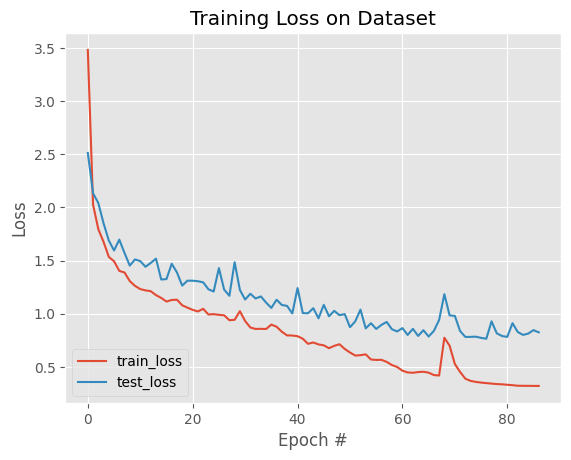

In [15]:
plt.style.use("ggplot")
plt.figure()
plt.plot(loss_list["train_loss"], label="train_loss")
plt.plot(loss_list["val_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
torch.save(model.state_dict(),MODEL_PATH)

## Evaluation

In [16]:
model_eval=UNet(N_CLASS)
model_eval.load_state_dict((torch.load(MODEL_PATH)))

<All keys matched successfully>

In [17]:
model_eval.eval()
total_ious = []
pixel_accs = []
jaccard_index=[]
with torch.no_grad():
  for (x, y) in testLoader:
    (x, y) = (x, y)
    x=x.to(DEVICE)
    y=y.to(DEVICE)
    pred = model_eval(x)                 
    pred=torch.argmax(pred,dim=1)
    for p, t in zip(pred, y):
      jaccard_index.append(jaccard(p, t))
      total_ious.append(iou(p, t, N_CLASS))
      pixel_accs.append(pixel_acc(p, t))
jaccards = torch.nanmean(torch.Tensor(jaccard_index))
ious = torch.nanmean(torch.Tensor(total_ious))
pixel_accs_mean = torch.nanmean(torch.Tensor(pixel_accs))
print("IoU: {}, pixel_accs_mean: {}, jaccard: {}".format(ious, pixel_accs_mean, jaccards))

IoU: 0.21359454095363617, pixel_accs_mean: 0.8434338569641113, jaccard: 0.2128768265247345


## Prediction

In [28]:
from prediction import make_predictions
N_CLASS=23
SAVED_MODEL_PATH="/Users/berce/Desktop/SS/SS_LAST/output/unet_orig_512_1024_10.pth"

In [29]:
model_eval=UNet(N_CLASS)
model_eval.load_state_dict((torch.load(SAVED_MODEL_PATH)))

<All keys matched successfully>

In [33]:
import pandas as pd
rgb_csv=pd.read_csv("/Users/berce/Desktop/SS/SS_LAST/class_dict_seg.csv")

In [34]:
cmap = np.array(list(rgb_csv[[' r', ' g', ' b']].transpose().to_dict('list').values()))
cmap = cmap[:len(cmap)-1,:]

[INFO] loading up test image paths...
[INFO] load up model...
(512, 1024)


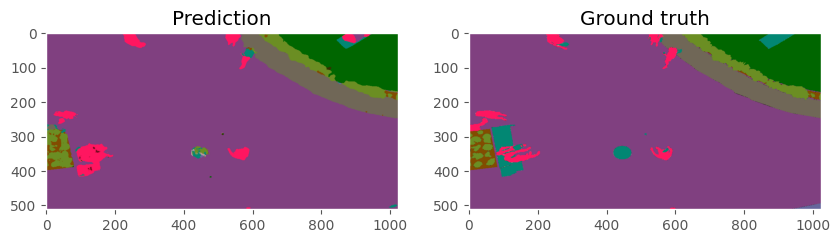

(512, 1024)


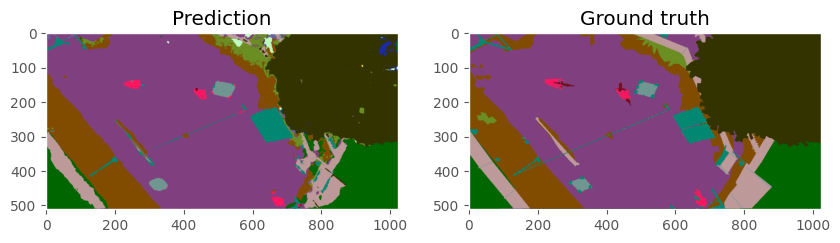

(512, 1024)


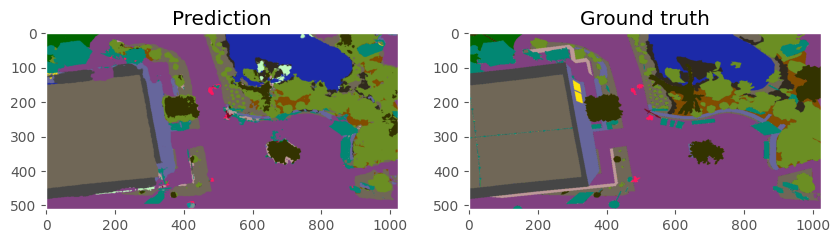

In [51]:
print("[INFO] loading up test image paths...")
imagePaths = open(TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=3)
print("[INFO] load up model...")
for image in imagePaths:
	make_predictions(model_eval, image,masked_path,cmap)